In [ ]:
# Problem Set 3

In [3]:
# Importss
! python -m pip install lightkurve --upgrade

  Using cached lightkurve-2.4.1-py3-none-any.whl (265 kB)
  Using cached uncertainties-3.1.7-py2.py3-none-any.whl (98 kB)
  Using cached memoization-0.4.0.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached oktopus-0.1.2.tar.gz (10 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached astroquery-0.4.6-py3-none-any.whl (4.5 MB)
  Using cached fbpca-1.0.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Using cached pyvo-1.4.2-py3-none-any.whl (888 kB)
  Using cached autograd-1.6.2-py3-none-any.whl (49 kB)
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=ee22a2d4161322806004a672046519af3863f3a7846a3fc06e1e266db5a38726
  Stored in directory: c:\users\julia\appdata\local\pip\cache\wheels\f5

In [28]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
lcs = lk.search_lightcurve("Kepler-7b", mission="Kepler", cadence="short").download_all()
time = lcs[0].time.value # get the time of each observation
flux = np.array(lcs[0].flux.value.data) # get the flux
flux_err = np.array(lcs[0].flux_err.value.data) # get the error in the flux

In [7]:
# Checking length of array
print(len(time))
print(len(flux))
print(len(flux_err))


43097
43097
43097


In [8]:
# Checking to see that values seem right
print(time[:10])
print(flux[:10])
print(flux_err[:10])


[260.21486737 260.21554845 260.21622962 260.2169107  260.21759177
 260.21827275 260.21895393 260.219635   260.22031608 260.22099725]
[       nan 106615.76  106603.38  106582.23  106545.555 106666.62
 106665.22  106607.21  106536.27  106570.01 ]
[      nan 51.50673  51.49249  51.479904 51.4641   51.474815 51.513138
 51.4481   51.427048 51.430946]


In [13]:
# Cleaning NaN values
mask = np.isnan(flux)
flux[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), flux[~mask])

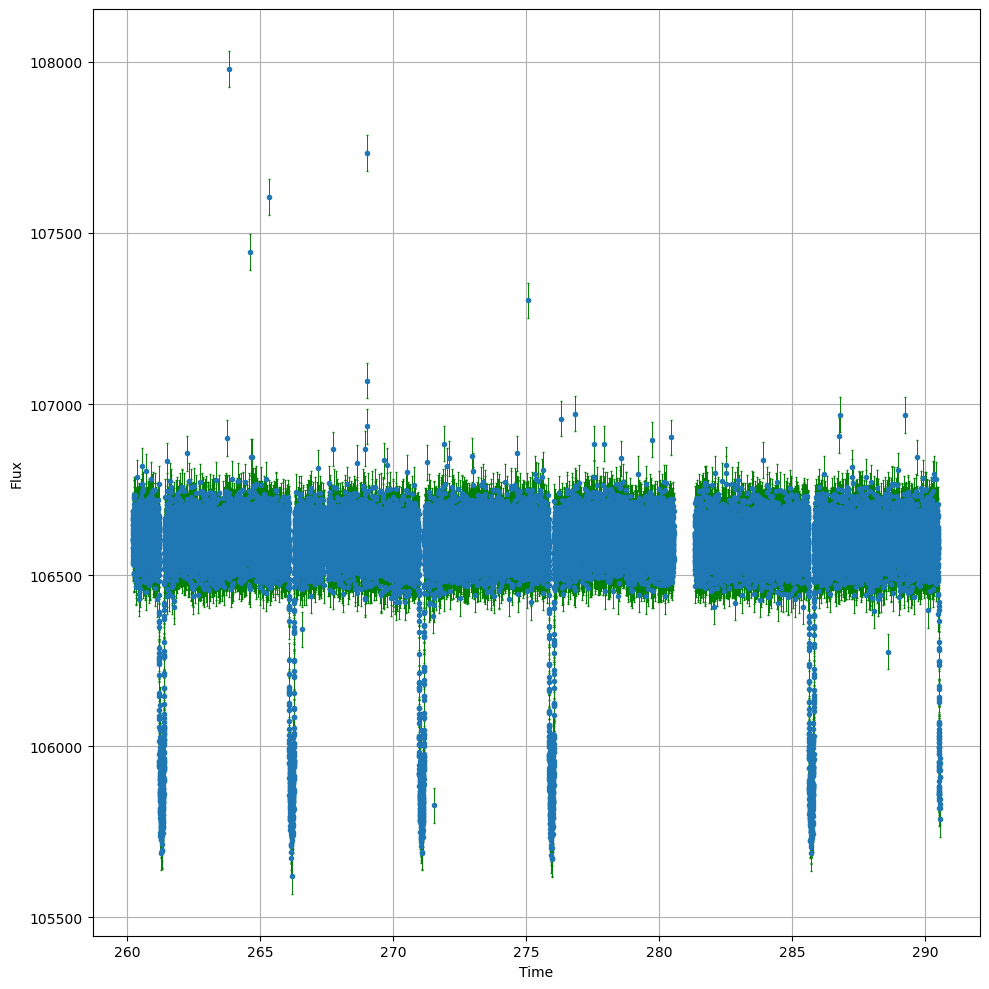

In [27]:
plt.figure(figsize=(10,10))
plt.errorbar(time, flux, yerr=flux_err, fmt= '.', elinewidth=0.7, ecolor='green', capsize=1)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.grid(True)
plt.tight_layout()
plt.show()